# Ubermag example: Vortex dynamics

In this Ubermag example, we are going to simulate vortex core dynamics. We are first going to displace it by applying an external magnetic field, and then turning it off to simulate the vortex core dynamics.

The sample is a two-dimensional Permalloy square sample with $d=100 \,\text{nm}$ edge length and $5\,\text{nm}$ thickness. Its energy equation consists of ferromagnetic exchange, Zeeman, and demagnetisation energy terms:
    
$$w = \int_{V} \left[-A\mathbf{m}\cdot\nabla^{2}\mathbf{m} - \mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H} + w_\text{d}\right] \text{d}V,$$

where $A = 13 \,\text{pJ}\,\text{m}^{-1}$ is the exchange energy constant, $M_\text{s} = 8 \times 10^{5} \,\text{A}\,\text{m}^{-1}$ magnetisation saturation, $w_\text{d}$ demagnetisation energy density, and $\mathbf{H}$ an external magnetic field, with $\mathbf{m}=\mathbf{M}/M_\text{s}$ being the normalised magnetisation field.

The magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation consisting of precession and damping terms:

$$\frac{\partial\mathbf{m}}{\partial t} = -\frac{\gamma_{0}}{1+\alpha^{2}}\mathbf{m}\times\mathbf{H}_\text{eff} - \frac{\gamma_{0}\alpha}{1+\alpha^{2}}\mathbf{m}\times(\mathbf{m}\times\mathbf{H}_\text{eff}),$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and $\alpha = 0.2$ is the Gilbert damping.

The (initial) magnetisation state is a vortex state, whose magnetisation at each point $(x, y, z)$ in the sample can be represented as $(m_{x}, m_{y}, m_{z}) = (-cy, cx, 0)$, with $c = 10^{9} \text{m}^{-1}$.

The Ubermag code for defining this micromagnetic system is:

In [1]:
import discretisedfield as df
import micromagneticmodel as mm

# Geometry
L = 100e-9  # sample edge length (m)
thickness = 5e-9  # sample thickness (m)

# Material (Permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 13e-12  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.2  # Gilbert damping

system = mm.System(name='vortex_dynamics')

# Energy equation. We omit Zeeman energy term, because H=0.
system.energy = mm.Exchange(A=A) + mm.Demag()

# Dynamics equation
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

region = df.Region(p1=(-L/2, -L/2, 0), p2=(L/2, L/2, thickness))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

def m_init(point):
    x, y, z = point
    c = 1e9  # (1/m)
    return (-c*y, c*x, 10)

system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

The system object is now defined and we can investigate some of its properties:

In [2]:
system.energy

Exchange(A=1.3e-11) + Demag()

In [3]:
system.dynamics

Precession(gamma0=221100.0) + Damping(alpha=0.2)

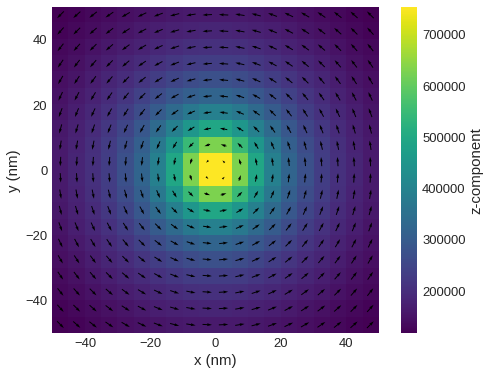

In [4]:
system.m.plane('z').mpl()

We can now relax the system.

Running OOMMF (ExeOOMMFRunner) [2021/03/12 17:35]... (0.9 s)


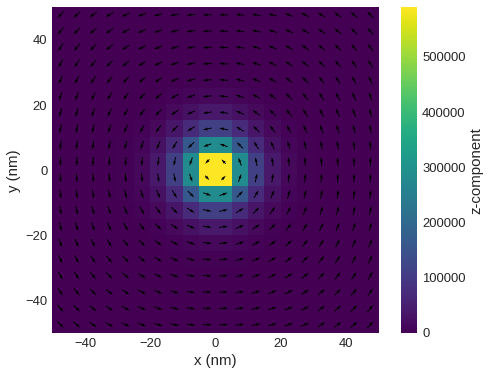

In [5]:
import oommfc as mc

md = mc.MinDriver()
md.drive(system)

system.m.plane('z').mpl()

Now we have a relaxed vortex state, with its core at the centre of the sample. As the next step, we want to add an external magnetic field in the positive $x$-direction to displace the vortex core.

Running OOMMF (ExeOOMMFRunner) [2021/03/12 17:35]... (1.1 s)


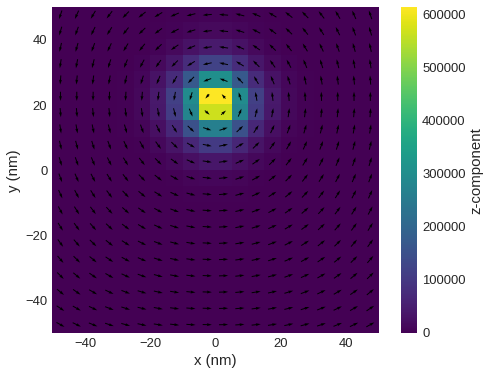

In [6]:
H = (1e4, 0, 0)  # an external magnetic field (A/m)

system.energy += mm.Zeeman(H=H)

md.drive(system)
system.m.plane('z').mpl()

The vortex core is now moved in the positive $y$-direction. As the last step, we are going to turn off the external magnetic field and simulate dynamics using `TimeDriver`. We are going to simulate for $5\,\text{ns}$ and save the magnetisation in $500$ steps.

In [7]:
system.energy.zeeman.H = (0, 0, 0)

td = mc.TimeDriver()
td.drive(system, t=5e-9, n=500)

Running OOMMF (ExeOOMMFRunner) [2021/03/12 17:35]... (5.5 s)


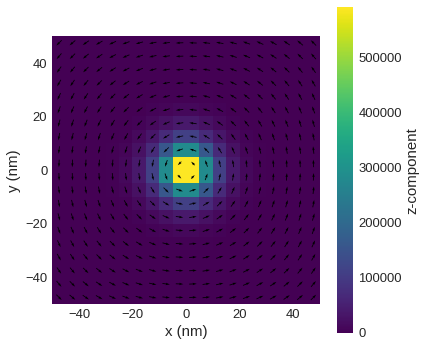

In [8]:
system.m.plane('z').mpl(figsize=(6, 6))

In [9]:
system.m.z.plane('z').k3d_scalar()

Output()

The table with scalar data collected during the simulation is:

In [10]:
system.table.data.tail()

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_exchange,max_spin_ang_exchange,stage_max_spin_ang_exchange,run_max_spin_ang_exchange,E_demag,E_zeeman,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
495,1.765512e-18,18364.0,1.354777,-1.013063e-15,-1.061038e-27,1.365677e-18,57.084570,57.084747,62.059729,3.998347e-19,0.0,3470.0,6.0,495.0,-0.000059,-0.000246,0.022938,9.864553e-13,4.960000e-09
496,1.765512e-18,18401.0,1.331959,-9.658813e-16,-1.008047e-27,1.365677e-18,57.083946,57.084570,62.059729,3.998347e-19,0.0,3477.0,6.0,496.0,-0.000038,-0.000244,0.022938,9.829044e-13,4.970000e-09
497,1.765512e-18,18438.0,1.311606,-9.231589e-16,-9.606878e-28,1.365677e-18,57.082998,57.083946,62.059729,3.998347e-19,0.0,3484.0,6.0,497.0,-0.000017,-0.000241,0.022938,9.790903e-13,4.980000e-09
498,1.765512e-18,18475.0,1.287092,-8.816371e-16,-9.196202e-28,1.365677e-18,57.081626,57.082998,62.059729,3.998346e-19,0.0,3491.0,6.0,498.0,0.000002,-0.000236,0.022938,9.803731e-13,4.990000e-09
499,1.765512e-18,18512.0,1.266743,-8.418464e-16,-8.797203e-28,1.365677e-18,57.079980,57.081626,62.059729,3.998346e-19,0.0,3498.0,6.0,499.0,0.000021,-0.000229,0.022938,9.809874e-13,5.000000e-09


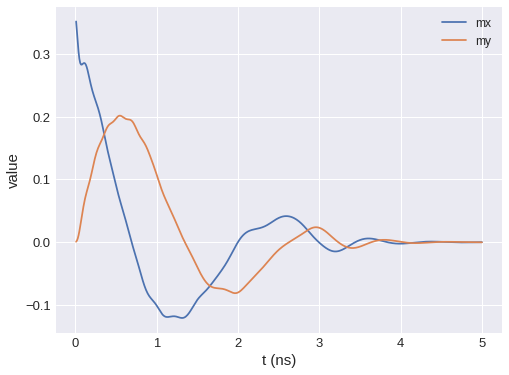

In [11]:
system.table.mpl(y=['mx', 'my'])

Finally, we are going to have a look at the magnetisation field at different time steps. For that, we are going to use `micromagneticdata` module. We introduce some basics here, but the details will be covered later. The main object is `Data` which requires us to pass the name we used when we created the system object.

In [12]:
import micromagneticdata as md

data = md.Data(system.name)
data.info

,drive_number,date,time,driver,t,n
0,0,2021-03-12,17:33:13,MinDriver,NaN,NaN
1,1,2021-03-12,17:33:40,MinDriver,NaN,NaN
2,2,2021-03-12,17:34:12,TimeDriver,5.000000e-09,500.0
3,3,2021-03-12,17:34:29,TimeDriver,5.000000e-09,500.0
4,4,2021-03-12,17:34:48,TimeDriver,5.000000e-09,500.0
5,5,2021-03-12,17:35:25,MinDriver,NaN,NaN
6,6,2021-03-12,17:35:26,MinDriver,NaN,NaN
7,7,2021-03-12,17:35:28,TimeDriver,5.000000e-09,500.0


In [13]:
@df.interact(nstep=data[-1].slider(continuous_update=False))
def our_interactive_plot(nstep):
    data[-1][nstep].plane('z').mpl()

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=499), Output()), _do…